Found 2602 images belonging to 5 classes.
Found 104 images belonging to 5 classes.
Epoch 1/3
82/82 ━━━━━━━━━━━━━━━━━━━━ 54s 574ms/step - accuracy: 0.6755 - loss: 0.8592 - val_accuracy: 0.9038 - val_loss: 0.2785
Epoch 2/3
82/82 ━━━━━━━━━━━━━━━━━━━━ 43s 519ms/step - accuracy: 0.9162 - loss: 0.2571 - val_accuracy: 0.8846 - val_loss: 0.2831
Epoch 3/3
82/82 ━━━━━━━━━━━━━━━━━━━━ 43s 519ms/step - accuracy: 0.9539 - loss: 0.1579 - val_accuracy: 0.8942 - val_loss: 0.2936
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 379ms/step - accuracy: 0.8657 - loss: 0.3858
Test Loss: 0.2841701805591583

Test Accuracy: 0.9038461446762085
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


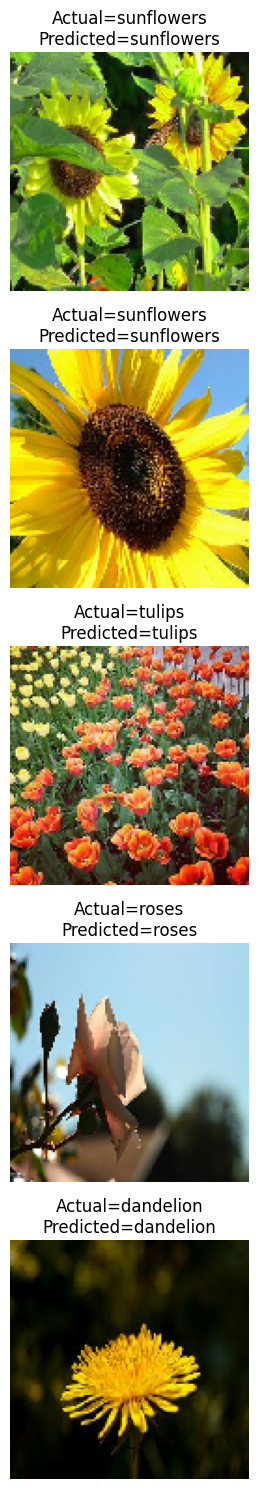

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import mixed_precision

# Set mixed precision training
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

# Load MobileNetV2 model with ImageNet weights and excluding the top layers
# Modify the model's input shape to (128, 128, 3)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False

# Add custom layers for the specific task
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(5, activation='softmax')(x)  # Update to 5 classes

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model with Adam optimizer and categorical cross-entropy loss
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Data augmentation and rescaling
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    horizontal_flip=True
    # You can experiment with other augmentations like zoom_range and shear_range here.
)

# Create the training data generator
train_generator = datagen.flow_from_directory(
    r"E:\Deep Learning Datasets-20241106T032755Z-001\Deep Learning Datasets\11 Flowers\train",  # Train directory
    target_size=(128, 128),  # Lower resolution for faster training
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

# Create the validation data generator (use a different directory for test)
validation_generator = datagen.flow_from_directory(
    r"E:\Deep Learning Datasets-20241106T032755Z-001\Deep Learning Datasets\11 Flowers\test",  # Test directory
    target_size=(128, 128),  # Lower resolution for faster training
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

# Train the model (reduced epochs for faster feedback)
history = model.fit(
    train_generator, 
    validation_data=validation_generator, 
    epochs=3,  # You can try a few more epochs if needed
    batch_size=64  # Increased batch size (adjust according to GPU memory)
)

# Evaluate the model on validation data
test_loss, test_acc = model.evaluate(validation_generator)

print("Test Loss:", test_loss)
print("\nTest Accuracy:", test_acc)

# Get predictions and plot results
x_val, y_val = next(validation_generator)
predictions = model.predict(x_val)
predicted_labels = np.argmax(predictions, axis=1)

# Display some sample results
n = 5
class_labels = list(train_generator.class_indices.keys())
plt.figure(figsize=(5, 15))
for i in range(n):
    plt.subplot(n, 1, i + 1)
    plt.imshow(x_val[i])
    actual_label = class_labels[np.argmax(y_val[i])]
    predicted_label = class_labels[predicted_labels[i]]
    plt.title(f"Actual={actual_label}\nPredicted={predicted_label}")
    plt.axis("off")
plt.tight_layout()
plt.show()